# Start

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
purchase_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Purchase Exit Survey Data')
airings_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Airings')

# The first row of Lookup table says "Lookup table for survey response field to airings network ticker symbol."  Assuming the first row always says that, we can drop it.
lookup_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Lookup', skiprows=1)

# Preprocessing

In [3]:
# Lookup data is meant to facilitate a join between the purchases data and the spend/lift data, but lookup data has a row will all null values, which doesn't help the join in any way.  I'll drop that row.
lookup_data = lookup_data.dropna(how='all')

# The Exit Survey column and Exit Survey.1 column are identical, so we can drop the duplicated column.
lookup_data.drop(labels='Exit Survey.1', axis=1, inplace=True)

In [4]:
# In order to make sure the joins happen correctly, we need to ensure that the strings we're joining on actually match.

# The purchase data table is pretty messy, but if we assume the second column always contains the names of the networks, we can use .iloc to grab them and ensure they're lowercase 

lookup_data['Exit Survey'] = lookup_data['Exit Survey'].str.lower()
lookup_data['Airings'] = lookup_data['Airings'].str.upper()
airings_data['Network'] = airings_data['Network'].str.upper()
purchase_data.iloc[:, 1] = purchase_data.iloc[:, 1].str.lower()

# Transposing Purchase Exit Survey Data - Converting dates from columns to rows in Purchase Exit Survey Data

The purchases table is extremely messy and would be easier to work with if the rows were dates and the columns were the networks.  If we assume that the first row will always have the year, the third row will always have month names, and the fourth row will always have the day numbers, I can programmatically concatenate all the necessary date information in the form "Year-Month-Day", then use them for the rows.

In [5]:
current_year = purchase_data.iloc[0,:].dropna()
current_year = int(current_year)
current_year

2017

In [6]:
months = []
for month in purchase_data.iloc[2,2:].dropna():
    months.append(month)
months

['September', 'October']

In [7]:
# Grab the row of day numbers and cast as integers
day_nums = np.array(purchase_data.iloc[3,2:], dtype=int)

parsed_dates = []
current_month = months[0]
i = 0

# Walk through the list of day_nums.  

# If current_day_num > next_day_num, that indicates a change in month (ex: If current_day = Sept-30 and next_day = Oct-1, b/c 30 > 1).  When this happens, we concatenate the current_day, then increase i by 1 to set the current_month to the next month for furture concatenation.  

# If current_day_num < next_day_num, that indicates both days are in the same month (ex: If current_day = Sept-5 and next_day = Sept-6, b/c 5 < 6), so we concatenate like normal.

# The try block handles the exception when you get to the last day in day_nums.  Since there are no more days in the list, we get an error when we try to index into the list one day into the future.
for count, current_day_num in enumerate(day_nums, start=1):
    try:
        next_day_num = day_nums[count]
    except:
        pass
    if current_day_num > next_day_num:
        current_date = str(current_year) + '-' + current_month + '-' + str(current_day_num)
        current_date = datetime.strptime(current_date, '%Y-%B-%d').date()
        i += 1
        current_month = months[i]
        parsed_dates.append(current_date)
    else:
        current_date = str(current_year) + '-' + current_month + '-' + str(current_day_num)
        current_date = datetime.strptime(current_date, '%Y-%B-%d').date()
        parsed_dates.append(current_date)

# Now that all the dates have been parsed, we replace the unparsed dates with the parsed ones, then transpose the table.  We now have rows that correspond to dates and columns that correspond to networks
purchase_data.iloc[3,2:] = parsed_dates
purchase_data_transpose = purchase_data.iloc[3:,:].transpose()

## Some Cleanup

In [8]:
# Set the column of dates as the index and rename the axis appropriately
#purchase_data_transpose.index = purchase_data_transpose.iloc[:, 0]
purchase_data_transpose.set_index(3, inplace=True)
purchase_data_transpose.rename_axis('date', inplace=True)

# Drop first row, which doesn't contain anything useful
purchase_data_transpose = purchase_data_transpose.iloc[1:]

# Replace column names with the row of network names and then drop that row
purchase_data_transpose.columns = purchase_data_transpose.iloc[0]
purchase_data_transpose = purchase_data_transpose.drop(labels='source')

# Rename column axis as upper-case "Source" to match original table
purchase_data_transpose.rename_axis('Source', axis='columns', inplace=True)

# Convert index of dates to datetime objects
purchase_data_transpose.index = pd.to_datetime(purchase_data_transpose.index)

In [9]:
# purchase_data_transpose.shape

In [10]:
purchase_data_transpose.head()

Source,(blank),aapka_colors,baby_first,bloomberg,cbs_sports,cnbc,cnn,comedy_central,dateline,dish_network,...,other,science,sony_entertainment_tv,spectrum_sports,star_plus,television_food_network,the_history_channel,turner_network_tv,willow_tv,zeetv
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
2017-09-03,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2017-09-04,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2017-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2017-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0,NaN


## Done

# Metrics by Network

## Purchases by Network

In [11]:
purchases_by_network = purchase_data_transpose.sum(axis=0)
purchases_by_network = purchases_by_network.to_frame()
purchases_by_network = purchases_by_network.rename(columns={0:'Purchases'})

In [12]:
# purchases_by_network.shape

In [13]:
# purchases_by_network.head()

## Spend and Lift by Network

In [14]:
spend_and_lift_by_network = airings_data.groupby('Network')[['Spend', 'Lift']].agg('sum')

In [15]:
# spend_and_lift_by_network.shape

In [16]:
# spend_and_lift_by_network.head()

## Joins

### Joining Purchases by Network to Lookup Data

In [17]:
purchases_by_network_w_lookup = lookup_data.merge(right=purchases_by_network, left_on='Exit Survey', right_on='Source', how='left')
purchases_by_network_w_lookup.set_index('Exit Survey', inplace=True)

In [18]:
# purchases_by_network_w_lookup.shape

In [19]:
# purchases_by_network_w_lookup.head()

### Joining Purchases/Lookup by Network to Spend and Lift

In [20]:
purchases_spend_lift_by_network = purchases_by_network_w_lookup.merge(right=spend_and_lift_by_network, left_on='Airings', right_index=True, how='left')

# Since this column was only needed for the join, I'm going to drop it post join
purchases_spend_lift_by_network.drop('Airings', axis=1, inplace=True)

In [21]:
# purchases_spend_lift_by_network.shape

In [22]:
# purchases_spend_lift_by_network.head()

In [23]:
purchases_spend_lift_by_network.index = purchases_spend_lift_by_network.index.str.replace('_', ' ').str.title()

In [24]:
purchases_spend_lift_by_network

,Purchases,Spend,Lift
Exit Survey,,,
(Blank),3.0,NaN,NaN
Aapka Colors,6.0,NaN,NaN
Baby First,1.0,NaN,NaN
Bloomberg,2.0,4966.72,199.0
Cbs Sports,1.0,NaN,NaN
Cnbc,15.0,6481.42,406.0
Cnn,23.0,18114.35,1081.0
Comedy Central,2.0,7501.25,108.0
Cozi,NaN,NaN,NaN


In [25]:
purchases_spend_lift_by_network.fillna(0, inplace=True)

In [26]:
cnbc_world = airings_data[airings_data['Network']=='CNBCWORLD']

In [27]:
cnbc_world[cnbc_world['Date/Time ET'].isnull()==True]

,Company,Date/Time ET,Rotation,Creative,Network,Spend,Lift,Program


## Computing Metrics by Network

In [28]:
purchases_spend_lift_by_network['Conversion Rate (Purchases/Lift)%'] = purchases_spend_lift_by_network['Purchases'] / purchases_spend_lift_by_network['Lift'] * 100

purchases_spend_lift_by_network['Cost Per Acquisition (Spend/Purchases)'] = purchases_spend_lift_by_network['Spend'] / purchases_spend_lift_by_network['Purchases'].fillna(0)

purchases_spend_lift_by_network['Cost Per Visitor (Spend/Lift)'] = purchases_spend_lift_by_network['Spend'] / purchases_spend_lift_by_network['Lift'].fillna(0)

purchases_spend_lift_by_network['Percent of Purchases'] = purchases_spend_lift_by_network['Purchases'] / sum(purchases_spend_lift_by_network['Purchases'].fillna(0)) * 100

purchases_spend_lift_by_network['Percent of Spend'] = purchases_spend_lift_by_network['Spend'] / sum(purchases_spend_lift_by_network['Spend'].fillna(0)) * 100

purchases_spend_lift_by_network['Percent Pur > Percent Spend'] = purchases_spend_lift_by_network['Percent of Purchases'] > purchases_spend_lift_by_network['Percent of Spend']

In [29]:
purchases_spend_lift_by_network

,Purchases,Spend,Lift,Conversion Rate (Purchases/Lift)%,Cost Per Acquisition (Spend/Purchases),Cost Per Visitor (Spend/Lift),Percent of Purchases,Percent of Spend,Percent Pur > Percent Spend
Exit Survey,,,,,,,,,
(Blank),3.0,0.00,0.0,inf,0.000000,NaN,1.271186,0.000000,True
Aapka Colors,6.0,0.00,0.0,inf,0.000000,NaN,2.542373,0.000000,True
Baby First,1.0,0.00,0.0,inf,0.000000,NaN,0.423729,0.000000,True
Bloomberg,2.0,4966.72,199.0,1.005025,2483.360000,24.958392,0.847458,2.242951,False
Cbs Sports,1.0,0.00,0.0,inf,0.000000,NaN,0.423729,0.000000,True
Cnbc,15.0,6481.42,406.0,3.694581,432.094667,15.964089,6.355932,2.926984,True
Cnn,23.0,18114.35,1081.0,2.127660,787.580435,16.757031,9.745763,8.180369,True
Comedy Central,2.0,7501.25,108.0,1.851852,3750.625000,69.456019,0.847458,3.387535,False
Cozi,0.0,0.00,0.0,NaN,NaN,NaN,0.000000,0.000000,False


In [30]:
# purchases_spend_lift_by_network

In [31]:
# purchases_spend_lift_by_network.shape

## Output results to CSV file

In [32]:
current_year_and_months = str(current_year) + '_' + '_'.join(str(month) for month in months)

purchases_spend_lift_by_network.to_csv(F"./cleaned_output/purchases_spend_lift_by_network_{current_year_and_months}.csv")

## Done

# Metrics by Network and Month

### BEGIN MONTHLY REPORT FIX

In [33]:
purchase_data_sept = purchase_data_transpose[purchase_data_transpose.index.month==9]
tot_purchase_data_sept = purchase_data_sept.sum().to_frame()

purchase_data_oct = purchase_data_transpose[purchase_data_transpose.index.month==10]
tot_purchase_data_oct = purchase_data_oct.sum().to_frame()

In [34]:
airings_data_sept = airings_data[airings_data['Date/Time ET'].dt.month==9]
airings_spend_and_lift_sept = airings_data_sept.groupby('Network').sum().reset_index()

airings_data_oct = airings_data[airings_data['Date/Time ET'].dt.month==10]
airings_spend_and_lift_oct = airings_data_oct.groupby('Network').sum().reset_index()

In [35]:
lookup_data_and_purchases_sept = lookup_data.merge(right=tot_purchase_data_sept, left_on='Exit Survey', right_on='Source', how='left')

lookup_data_and_purchases_oct = lookup_data.merge(right=tot_purchase_data_oct, left_on='Exit Survey', right_on='Source', how='left')

In [36]:
purchases_spend_lift_sept = lookup_data_and_purchases_sept.merge(right=airings_spend_and_lift_sept, left_on='Airings', right_on='Network', how='left').rename(columns={0:'Purchases'})

purchases_spend_lift_oct = lookup_data_and_purchases_oct.merge(right=airings_spend_and_lift_oct, left_on='Airings', right_on='Network', how='left').rename(columns={0:'Purchases'})

In [37]:
purchases_spend_lift_sept[purchases_spend_lift_sept['Exit Survey']=='bloomberg'][['Purchases', 'Spend', 'Lift']].fillna(0)

,Purchases,Spend,Lift
3,1.0,4966.72,199.0


In [38]:
purchases_spend_lift_oct[purchases_spend_lift_sept['Exit Survey']=='bloomberg'][['Purchases', 'Spend', 'Lift']].fillna(0)

,Purchases,Spend,Lift
3,1.0,0.0,0.0


In [39]:
x='fyi'
purchases_spend_lift_sept[purchases_spend_lift_sept['Exit Survey']==x][['Purchases', 'Spend', 'Lift']].fillna(0) + purchases_spend_lift_oct[purchases_spend_lift_sept['Exit Survey']==x][['Purchases', 'Spend', 'Lift']].fillna(0)

,Purchases,Spend,Lift
15,2.0,0.0,0.0


In [40]:
purchases_spend_lift_sept['Month'] = 'September'

In [41]:
purchases_spend_lift_oct['Month'] = 'October'

In [42]:
# pd.concat([purchases_spend_lift_sept, purchases_spend_lift_oct]).set_index(['Exit Survey', 'Month'])

In [43]:
purchases_spend_lift_sept['Exit Survey'] = purchases_spend_lift_sept['Exit Survey'].str.replace('_', ' ').str.title()

In [44]:
purchases_spend_lift_oct['Exit Survey'] = purchases_spend_lift_oct['Exit Survey'].str.replace('_', ' ').str.title()

In [45]:
purchases_spend_lift_sept.rename(columns={"Exit Survey": "Exit Survey Source"}, inplace=True)

In [46]:
purchases_spend_lift_oct.rename(columns={"Exit Survey": "Exit Survey Source"}, inplace=True)

In [47]:
purchases_spend_lift_sept = purchases_spend_lift_sept.set_index(['Exit Survey Source', 'Month']).drop(labels=['Airings', 'Network'], axis=1)

In [48]:
purchases_spend_lift_oct = purchases_spend_lift_oct.set_index(['Exit Survey Source', 'Month']).drop(labels=['Airings', 'Network'], axis=1)

In [49]:
purchases_spend_lift_sept.fillna(0, inplace=True)

In [50]:
purchases_spend_lift_oct.fillna(0, inplace=True)

In [51]:
purchases_spend_lift_sept['Conversion Rate (Purchases/Lift)%'] = purchases_spend_lift_sept['Purchases'] / purchases_spend_lift_sept['Lift'] * 100

purchases_spend_lift_sept['Cost Per Acquisition (Spend/Purchases)'] = purchases_spend_lift_sept['Spend'] / purchases_spend_lift_sept['Purchases']

purchases_spend_lift_sept['Cost Per Visitor (Spend/Lift)'] = purchases_spend_lift_sept['Spend'] / purchases_spend_lift_sept['Lift']

purchases_spend_lift_sept['Percent of Purchases'] = purchases_spend_lift_sept['Purchases'] / sum(purchases_spend_lift_sept['Purchases'].fillna(0)) * 100

purchases_spend_lift_sept['Percent of Spend'] = purchases_spend_lift_sept['Spend'] / sum(purchases_spend_lift_sept['Spend'].fillna(0)) * 100

purchases_spend_lift_sept['Percent Pur > Percent Spend'] = purchases_spend_lift_sept['Percent of Purchases'] > purchases_spend_lift_sept['Percent of Spend']

In [52]:
purchases_spend_lift_oct['Conversion Rate (Purchases/Lift)%'] = purchases_spend_lift_oct['Purchases'] / purchases_spend_lift_oct['Lift'] * 100

purchases_spend_lift_oct['Cost Per Acquisition (Spend/Purchases)'] = purchases_spend_lift_oct['Spend'] / purchases_spend_lift_oct['Purchases']

purchases_spend_lift_oct['Cost Per Visitor (Spend/Lift)'] = purchases_spend_lift_oct['Spend'] / purchases_spend_lift_oct['Lift']

purchases_spend_lift_oct['Percent of Purchases'] = purchases_spend_lift_oct['Purchases'] / sum(purchases_spend_lift_oct['Purchases'].fillna(0)) * 100

purchases_spend_lift_oct['Percent of Spend'] = purchases_spend_lift_oct['Spend'] / sum(purchases_spend_lift_oct['Spend'].fillna(0)) * 100

purchases_spend_lift_oct['Percent Pur > Percent Spend'] = purchases_spend_lift_oct['Percent of Purchases'] > purchases_spend_lift_oct['Percent of Spend']

In [53]:
purchases_spend_lift_sept.head()

,,Purchases,Spend,Lift,Conversion Rate (Purchases/Lift)%,Cost Per Acquisition (Spend/Purchases),Cost Per Visitor (Spend/Lift),Percent of Purchases,Percent of Spend,Percent Pur > Percent Spend
Exit Survey Source,Month,,,,,,,,,
(Blank),September,0.0,0.00,0.0,NaN,NaN,NaN,0.000000,0.000000,False
Aapka Colors,September,1.0,0.00,0.0,inf,0.00,NaN,0.952381,0.000000,True
Baby First,September,1.0,0.00,0.0,inf,0.00,NaN,0.952381,0.000000,True
Bloomberg,September,1.0,4966.72,199.0,0.502513,4966.72,24.958392,0.952381,4.601834,False
Cbs Sports,September,1.0,0.00,0.0,inf,0.00,NaN,0.952381,0.000000,True


In [54]:
purchases_spend_lift_oct.head()

,,Purchases,Spend,Lift,Conversion Rate (Purchases/Lift)%,Cost Per Acquisition (Spend/Purchases),Cost Per Visitor (Spend/Lift),Percent of Purchases,Percent of Spend,Percent Pur > Percent Spend
Exit Survey Source,Month,,,,,,,,,
(Blank),October,3.0,0.0,0.0,inf,0.0,NaN,2.290076,0.0,True
Aapka Colors,October,5.0,0.0,0.0,inf,0.0,NaN,3.816794,0.0,True
Baby First,October,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.0,False
Bloomberg,October,1.0,0.0,0.0,inf,0.0,NaN,0.763359,0.0,True
Cbs Sports,October,0.0,0.0,0.0,NaN,NaN,NaN,0.000000,0.0,False


### END MONTHLY REPORT FIX

## BEGIN OLD MONTHLY REPORTS - Purchases by Network and Month

In [55]:
# GroupBy month to find purchases per month for each network
purchase_data_by_month = purchase_data_transpose.groupby(pd.Grouper(freq='M')).agg('sum')

In [56]:
purchase_data_by_month

Source,(blank),aapka_colors,baby_first,bloomberg,cbs_sports,cnbc,cnn,comedy_central,dateline,dish_network,...,other,science,sony_entertainment_tv,spectrum_sports,star_plus,television_food_network,the_history_channel,turner_network_tv,willow_tv,zeetv
date,,,,,,,,,,,,,,,,,,,,,
2017-09-30,0.0,1.0,1.0,1.0,1.0,5.0,13.0,0.0,0.0,4.0,...,5.0,1.0,2.0,2.0,2.0,4.0,4.0,2.0,27.0,2.0
2017-10-31,3.0,5.0,0.0,1.0,0.0,10.0,10.0,2.0,10.0,1.0,...,8.0,3.0,2.0,1.0,2.0,0.0,1.0,2.0,29.0,3.0


In [57]:
# Transpose so that the name of network becomes the rows and purchases per month become columns
purchase_data_by_month = purchase_data_by_month.transpose()

# Stack so that the index of each row corresponds to a network for a given month and row values are the number of purchases for that network in that month
purchase_data_by_month = purchase_data_by_month.stack().to_frame()

# Rename purchases column
purchase_data_by_month.rename(columns={0:'Purchases'}, inplace=True)

# Reset_index to set up for merging tables.  It will be easier to merge by column that by index in future steps
purchase_data_by_month = purchase_data_by_month.reset_index()

In [58]:
# purchase_data_by_month.head()

In [59]:
# purchase_data_by_month.shape

## Spend and Lift by Network and Month

In [60]:
spend_lift_by_network_month = airings_data.groupby(['Network', pd.Grouper(key='Date/Time ET', freq='M')])[['Spend', 'Lift']].agg('sum')

## Joins

### Joining Purchases by Network and Month to Lookup Data

In [61]:
purchases_by_month_with_lookup = lookup_data.merge(right=purchase_data_by_month, left_on='Exit Survey', right_on='Source', how='left').set_index(['Exit Survey', 'date'])

In [62]:
# print(purchases_by_month_with_lookup.head().to_string())

In [63]:
# purchases_by_month_with_lookup.shape

### Joining Purchases/Lookup by Network and Month to Spend and Lift

In [64]:
purchases_spend_lift_by_network_and_month = purchases_by_month_with_lookup.reset_index().merge(right=spend_lift_by_network_month.reset_index(), left_on=['Airings', 'date'], right_on=['Network', 'Date/Time ET'], how='left')

In [65]:
purchases_spend_lift_by_network_and_month.head()

,Exit Survey,date,Airings,Source,Purchases,Network,Date/Time ET,Spend,Lift
0,(blank),2017-09-30,NaN,(blank),0.0,NaN,NaT,NaN,NaN
1,(blank),2017-10-31,NaN,(blank),3.0,NaN,NaT,NaN,NaN
2,aapka_colors,2017-09-30,NaN,aapka_colors,1.0,NaN,NaT,NaN,NaN
3,aapka_colors,2017-10-31,NaN,aapka_colors,5.0,NaN,NaT,NaN,NaN
4,baby_first,2017-09-30,BABY,baby_first,1.0,NaN,NaT,NaN,NaN


In [66]:
# purchases_spend_lift_by_network_and_month.shape

In [67]:
purchases_spend_lift_by_network_and_month['Exit Survey'] = purchases_spend_lift_by_network_and_month['Exit Survey'].str.replace('_', ' ').str.title()

In [68]:
purchases_spend_lift_by_network_and_month.rename(columns={"Exit Survey": "Exit Survey Source"}, inplace=True)

In [69]:
purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month.set_index(['Exit Survey Source', 'date']).drop(labels=['Airings', 'Network', 'Date/Time ET', 'Source'], axis=1)

In [70]:
# purchases_spend_lift_by_network_and_month.head()

In [71]:
# purchases_spend_lift_by_network_and_month.shape

In [72]:
# print(purchases_spend_lift_by_network_and_month.head().to_string())

In [73]:
purchases_spend_lift_by_network_and_month.fillna(0, inplace=True)

## Computing Metrics by Network and Month

In [74]:
purchases_spend_lift_by_network_and_month['Conversion Rate (Purchases/Lift)%'] = purchases_spend_lift_by_network_and_month['Purchases'] / purchases_spend_lift_by_network_and_month['Lift'] * 100

purchases_spend_lift_by_network_and_month['Cost Per Acquisition (Spend/Purchases)'] = purchases_spend_lift_by_network_and_month['Spend'] / purchases_spend_lift_by_network_and_month['Purchases']

purchases_spend_lift_by_network_and_month['Cost Per Visitor (Spend/Lift)'] = purchases_spend_lift_by_network_and_month['Spend'] / purchases_spend_lift_by_network_and_month['Lift']

purchases_spend_lift_by_network_and_month['Percent of Purchases'] = purchases_spend_lift_by_network_and_month['Purchases'] / sum(purchases_spend_lift_by_network_and_month['Purchases'].fillna(0)) * 100

purchases_spend_lift_by_network_and_month['Percent of Spend'] = purchases_spend_lift_by_network_and_month['Spend'] / sum(purchases_spend_lift_by_network_and_month['Spend'].fillna(0)) * 100

purchases_spend_lift_by_network_and_month['Percent Pur > Percent Spend'] = purchases_spend_lift_by_network_and_month['Percent of Purchases'] > purchases_spend_lift_by_network_and_month['Percent of Spend']

In [75]:
# purchases_spend_lift_by_network_and_month.head()

In [76]:
# print(purchases_spend_lift_by_network_and_month.head().to_string())

## Output results to CSV file

In [77]:
purchases_spend_lift_by_network_and_month.to_csv(F"./cleaned_output/purchases_spend_lift_by_network_and_month_{current_year_and_months}.csv")

## Done

In [78]:
# airings_data.index = pd.to_datetime(airings_data['Date/Time ET'])

# airings_data[airings_data['Network']=='COM'].groupby(pd.Grouper(freq='M')).sum()

## END OLD MONTHLY REPORTS 

# Generating Reports

## Overall report by network

In [79]:
report_for_client = purchases_spend_lift_by_network.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

report_for_client.query('Spend != 0', inplace=True)

In [80]:
report_for_client[['Purchases', 'Lift']] = report_for_client[['Purchases', 'Lift']].astype(int)

report_for_client = report_for_client.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})


report_for_client.rename_axis('Exit Survey Source', axis=0, inplace=True)

report_for_client = report_for_client.sort_values('Exit Survey Source')

In [81]:
# report_for_client

## Monthly report by network

### BEGIN NEW WORK

In [82]:
report_for_client_sept = purchases_spend_lift_sept.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

report_for_client_sept.query('Spend != 0', inplace=True)

In [83]:
report_for_client_oct = purchases_spend_lift_oct.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

report_for_client_oct.query('Spend != 0', inplace=True)

In [84]:
report_for_client_sept = report_for_client_sept.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})

report_for_client_sept[['Purchases', 'Lift']] = report_for_client_sept[['Purchases', 'Lift']].astype(int)

report_for_client_sept = report_for_client_sept.sort_values('Exit Survey Source')

In [85]:
report_for_client_oct = report_for_client_oct.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})

report_for_client_oct[['Purchases', 'Lift']] = report_for_client_oct[['Purchases', 'Lift']].astype(int)

report_for_client_oct = report_for_client_oct.sort_values('Exit Survey Source')

### END NEW WORK

### BEGIN OLD WORK

In [86]:
report_for_client_by_month = purchases_spend_lift_by_network_and_month.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

#report_for_client_by_month.query('Spend != 0', inplace=True)

In [87]:
report_for_client_by_month = report_for_client_by_month.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})

report_for_client_by_month[['Purchases', 'Lift']] = report_for_client_by_month[['Purchases', 'Lift']].astype(int)

In [88]:
report_for_client_by_month = report_for_client_by_month.loc[report_for_client.index]

### END OLD WORK

## Exporting Results to PDF Files

In [89]:
import pdfkit

f = open('./reports_output/html/report_for_client.html','w')
a = report_for_client.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client.html', './reports_output/pdfs/report_for_client.pdf')

True

### BEGIN NEW WORK

In [90]:
f = open('./reports_output/html/report_for_client_sept.html','w')
a = report_for_client_sept.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client_sept.html', './reports_output/pdfs/report_for_client_sept.pdf')

True

In [91]:
f = open('./reports_output/html/report_for_client_oct.html','w')
a = report_for_client_oct.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client_oct.html', './reports_output/pdfs/report_for_client_oct.pdf')

True

### END NEW WORK

### BEGIN OLD WORK

In [92]:
f = open('./reports_output/html/report_for_client_by_month.html','w')
a = report_for_client_by_month.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client_by_month.html', './reports_output/pdfs/report_for_client_by_month.pdf')

True

### END OLD WORK

# Presentation 

## How much does it cost to acquire a customer through TV?

## Cost Efficiency

In [93]:
# For a channel to be cost-efficient, I'm going to limit my scope to only channels where money was spent on advertising there.
report_for_client[report_for_client['Spend']>0]['Cost Per Visitor (Spend/Lift)'].sort_values()[0:5].to_frame()

,Cost Per Visitor (Spend/Lift)
Exit Survey Source,
Dish Network,2.78
Willow Tv,5.81
Star Plus,6.61
Msnbc,10.09
One America News Network,10.51


In [94]:
# For a channel to be cost-efficient, I'm going to limit my scope to only channels where money was spent on advertising there.
report_for_client[report_for_client['Spend']>0]['Cost Per Visitor (Spend/Lift)'].sort_values(ascending=False)[0:5].to_frame()

,Cost Per Visitor (Spend/Lift)
Exit Survey Source,
Comedy Central,69.46
Science,60.55
The Weather Channel,36.58
Turner Network Tv,28.63
Nfl Network,27.06


In [95]:
# For a channel to be cost-efficient, I'm going to limit my scope to only channels where money was spent on advertising there.

## Note: Both CNBC World and The Weather Channel had ZERO purchases, so despite the sort order, they technically have the worst Cost Per Acquisition
report_for_client[report_for_client['Spend']>0]['Cost Per Acquisition (Spend/Purchases)'].sort_values()[2:7].to_frame()

,Cost Per Acquisition (Spend/Purchases)
Exit Survey Source,
Msnbc,708.13
Cnn,787.58
Willow Tv,852.40
Turner Network Tv,1281.38
The History Channel,1455.66


In [96]:
report_for_client[report_for_client['Spend']>0]['Cost Per Acquisition (Spend/Purchases)'].sort_values(ascending=False)

Exit Survey Source
Cnbc World                      inf
The Weather Channel             inf
Zeetv                       5120.85
Comedy Central              3750.62
Star Plus                   2945.14
Bloomberg                   2483.36
Fox Sports                  2129.25
Science                     1998.30
Spectrum Sports             1860.09
Nfl Network                 1804.27
One America News Network    1558.44
Dateline                    1528.81
The History Channel         1455.66
Turner Network Tv           1281.38
Willow Tv                    852.40
Cnn                          787.58
Msnbc                        708.13
Dish Network                 606.67
Cnbc                         432.09
Name: Cost Per Acquisition (Spend/Purchases), dtype: float64

In [97]:
# For a channel to be cost-efficient, I'm going to limit my scope to only channels where money was spent on advertising there.

report_for_client[report_for_client['Spend']>0]['Conversion Rate (Purchases/Lift)%'].sort_values(ascending=False)

Exit Survey Source
Cnbc                        3.7
Science                     3.0
Turner Network Tv           2.2
Cnn                         2.1
Comedy Central              1.9
Nfl Network                 1.5
The History Channel         1.5
Msnbc                       1.4
Spectrum Sports             1.4
Dateline                    1.2
Fox Sports                  1.1
Bloomberg                   1.0
One America News Network    0.7
Willow Tv                   0.7
Dish Network                0.5
Zeetv                       0.3
Star Plus                   0.2
The Weather Channel         0.0
Cnbc World                  0.0
Name: Conversion Rate (Purchases/Lift)%, dtype: float64

## Which Networks have highest purchases?

In [98]:
num_purchases_by_network = purchases_spend_lift_by_network.groupby("Exit Survey")['Purchases'].agg('sum')

tot_purchases = sum(num_purchases_by_network)

percent_purchases_by_network = num_purchases_by_network / tot_purchases * 100
percent_purchases_by_network = percent_purchases_by_network.sort_values(ascending=False)

percent_purchases_by_network

Exit Survey
Willow Tv                   23.728814
Cnn                          9.745763
Msnbc                        6.779661
One America News Network     6.779661
Cnbc                         6.355932
Fox News                     5.932203
Other                        5.508475
Dateline                     4.237288
Aapka Colors                 2.542373
Hgtv                         2.542373
Dish Network                 2.118644
The History Channel          2.118644
Zeetv                        2.118644
Star Plus                    1.694915
Sony Entertainment Tv        1.694915
Science                      1.694915
Espn                         1.694915
Television Food Network      1.694915
Turner Network Tv            1.694915
Spectrum Sports              1.271186
Nfl Network                  1.271186
(Blank)                      1.271186
Fyi                          0.847458
Fox Sports                   0.847458
Diy                          0.847458
Comedy Central               0.847458


## Which Networks have no spend but high purchases?

In [99]:
num_purchases_no_spend = report_for_client[report_for_client['Spend']==0].groupby("Exit Survey Source")['Purchases'].agg('sum')

tot_purchases_no_spend = sum(num_purchases_no_spend)

perc_purchases_no_spend = num_purchases_no_spend / tot_purchases_no_spend * 100
perc_purchases_no_spend = perc_purchases_no_spend.sort_values(ascending=False)

perc_purchases_no_spend
# (report_for_client[report_for_client['Spend']==0].groupby("Exit Survey Source")['Purchases'].agg('sum') / sum(report_for_client[report_for_client['Spend']==0].groupby("Exit Survey Source")['Purchases'].agg('sum')) * 100).sort_values(ascending=False)

Series([], Name: Purchases, dtype: float64)

## Need to Redo using report_for_client... - Overall Metrics - Establishing a baseline

In [100]:
total_purchases = sum(purchases_spend_lift_by_network['Purchases'].fillna(0))
total_spend = sum(purchases_spend_lift_by_network['Spend'].fillna(0))
total_lift = sum(purchases_spend_lift_by_network['Lift'].fillna(0))

In [101]:
mean_purchases = purchases_spend_lift_by_network['Purchases'].mean()
mean_spend = purchases_spend_lift_by_network['Spend'].mean()
mean_lift = purchases_spend_lift_by_network['Lift'].mean()

print(F"Average number purchases: {round(mean_purchases)}")
print(F"Average spend: ${round(mean_spend,2)}")
print(F"Average lift: {round(mean_lift)}")

Average number purchases: 5
Average spend: $5149.69
Average lift: 476


In [102]:
mean_conversion_rate = purchases_spend_lift_by_network['Conversion Rate (Purchases/Lift)%'].mean()
mean_cpa = purchases_spend_lift_by_network['Cost Per Acquisition (Spend/Purchases)'].mean()
mean_cost_per_visitor = purchases_spend_lift_by_network['Cost Per Visitor (Spend/Lift)'].mean()

print(F"Average Cost Per Visitor: ${round(mean_cost_per_visitor)}")
print(F"Average Conversion Rate: {round(mean_conversion_rate,1)}%")
print(F"Average Cost Per Acquisition: ${round(mean_cpa,2)}")

Average Cost Per Visitor: $23
Average Conversion Rate: inf%
Average Cost Per Acquisition: $inf


In [103]:
report_for_client['Spend'].mean()

11654.57052631579

### Cost Per Visitor = $ \frac{\text{total spend}}{\text{total lift}}$

In [104]:
cost_per_visitor = total_spend / total_lift
cost_per_visitor = round(cost_per_visitor, 2)
print(F"The overall cost per visitor for the TV campaign is ${cost_per_visitor}")

The overall cost per visitor for the TV campaign is $10.81


### Conversion Rate = $ \frac{\text{total # of purchases}}{\text{total lift}} $

In [105]:
conversion_rate =  total_purchases / total_lift
conversion_rate = round(conversion_rate * 100, 2)
print(F"The overall conversion rate for the TV campaign is {conversion_rate}%")

The overall conversion rate for the TV campaign is 1.15%


### Cost Per Acquisition = $ \frac{\text{total spend}}{\text{total # of purchases}} $

In [106]:
cost_per_acquisition = total_spend / total_purchases
cost_per_acquisition = round(cost_per_acquisition, 2)
print(F"The overall cost per acquisition for the TV campaign is ${cost_per_acquisition}")

The overall cost per acquisition for the TV campaign is $938.29


# Graphing

In [107]:
import matplotlib.pyplot as plt

## Bar Charts

In [108]:
ax = report_purchases_sorted[0:10].plot(kind='barh', y='Purchases', title='Top 10 Networks by Purchase', legend=False)
ax.invert_yaxis()
ax.set_xlabel('Number of Purchases');

NameError: name 'report_purchases_sorted' is not defined

In [ ]:
ax = report_purchases_sorted[-10:].plot(kind='barh', y='Purchases', title='Bottom 10 Networks by Purchase', legend=False)
ax.invert_yaxis()
ax.set_xlabel('Number of Purchases')
ax.set_xticks(np.arange(0,3,1));

In [ ]:
ax = report_purchases_sorted[0:10].plot(kind='barh', y='Purchases', title='Top 10 Networks by Purchase', legend=False, color='blue')
ax.invert_yaxis()
ax.set_xlabel('Number of Purchases')
ax1 = ax.twiny()
report_purchases_sorted[0:10].plot(kind='barh', y='Spend', title='Top 10 Networks by Purchase', legend=False, ax=ax, color='r');

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Purchases')


ax2 = ax.twiny()
ax2.set_xlabel('Amount Spent ($)')


bar1 = report_purchases_sorted['Purchases'][0:10].plot(kind='barh', color='green', position=1, width=0.4, ax=ax, label='Purchases')
bar2 = report_purchases_sorted['Spend'][0:10].plot(kind='barh', color='red', position=0, width=0.4, ax=ax2, label='Spend')

#ax2.invert_yaxis()
plt.ylim((-0.5, len(report_purchases_sorted[0:10])-0.5))
ax.invert_yaxis()

bars, labels = ax.get_legend_handles_labels()
bars2, labels2 = ax2.get_legend_handles_labels()
ax.legend(bars+bars2, labels+labels2, loc='lower right')

;

NameError: name 'report_purchases_sorted' is not defined

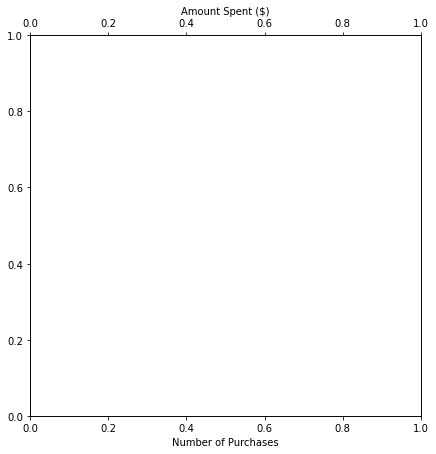

In [109]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Purchases')


ax2 = ax.twiny()
ax2.set_xlabel('Amount Spent ($)')


report_purchases_sorted['Purchases'][-10:].plot(kind='barh', color='blue', position=1, width=0.4, ax=ax)
report_purchases_sorted['Spend'][-10:].plot(kind='barh', color='red', position=0, width=0.4, ax=ax2)
ax.invert_yaxis()
#ax2.invert_yaxis()
plt.ylim((-0.5, len(report_purchases_sorted[0:10])-0.5));

## Heatmaps

In [110]:
import seaborn as sns

<AxesSubplot:ylabel='Exit Survey Source'>

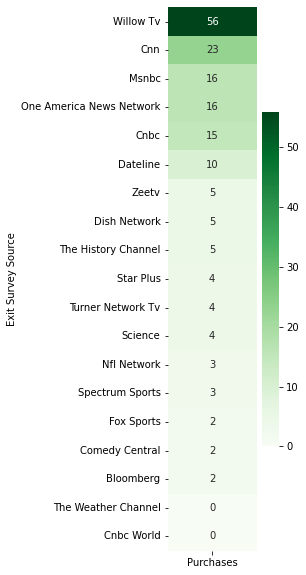

In [111]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Purchases']].sort_values(by='Purchases', ascending=False), annot=True, cmap='Greens', vmin=0, fmt='g')

<AxesSubplot:ylabel='Exit Survey Source'>

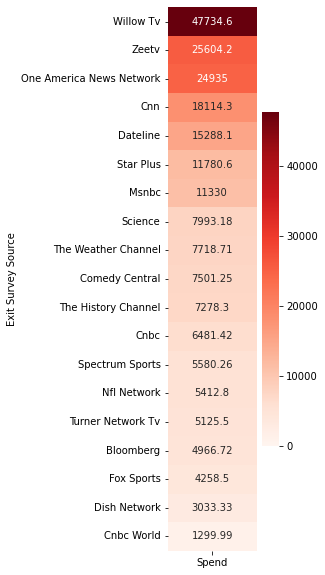

In [112]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Spend']].sort_values(by='Spend', ascending=False), annot=True, cmap='Reds', vmin=0, fmt='g')

<AxesSubplot:ylabel='Exit Survey Source'>

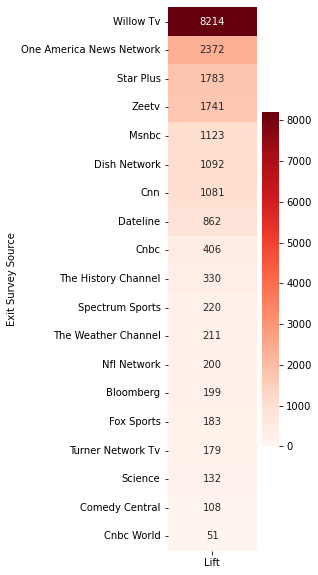

In [113]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Lift']].sort_values(by='Lift', ascending=False), annot=True, cmap='Reds', vmin=0, fmt='g')

<AxesSubplot:ylabel='Exit Survey Source'>

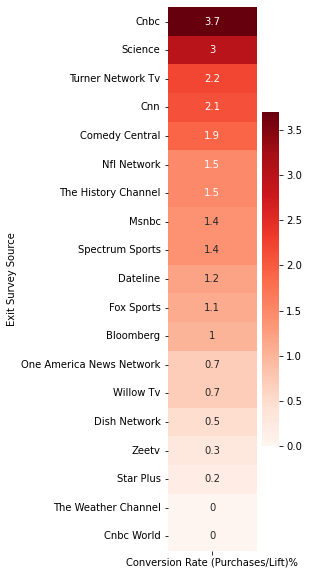

In [114]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Conversion Rate (Purchases/Lift)%']].sort_values(by='Conversion Rate (Purchases/Lift)%', ascending=False), annot=True, cmap='Reds', vmin=0, fmt='g')

<AxesSubplot:ylabel='Exit Survey Source'>

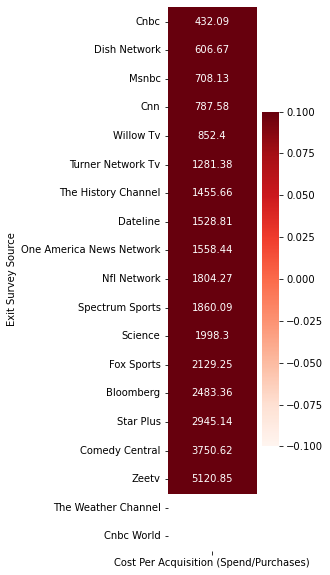

In [128]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Cost Per Acquisition (Spend/Purchases)']].sort_values(by='Cost Per Acquisition (Spend/Purchases)', ascending=True)[:], annot=True, cmap='Reds', vmin=0, fmt='g')

<AxesSubplot:ylabel='Exit Survey Source'>

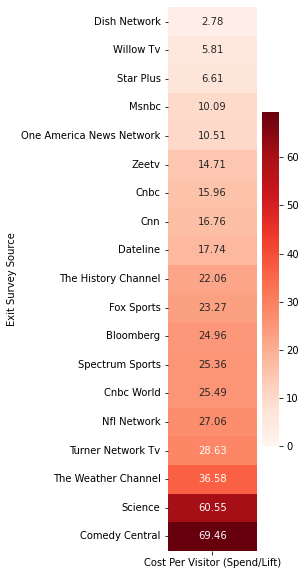

In [123]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Cost Per Visitor (Spend/Lift)']].sort_values(by='Cost Per Visitor (Spend/Lift)', ascending=True), annot=True, cmap='Reds', vmin=0, fmt='g')

<AxesSubplot:ylabel='Exit Survey Source'>

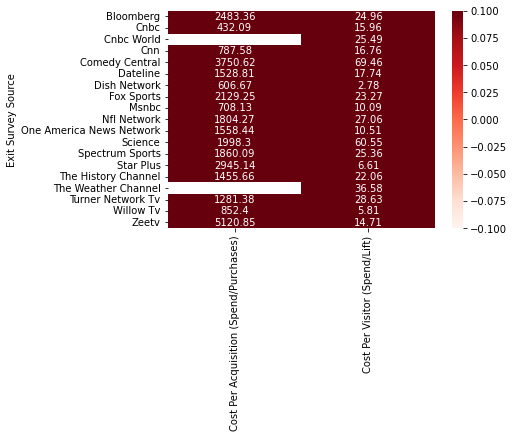

In [117]:
#fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(report_for_client[['Cost Per Acquisition (Spend/Purchases)', 'Cost Per Visitor (Spend/Lift)']], annot=True, cmap='Reds', vmin=0, fmt='g')

## Plotting Function - make_scatter()

In [ ]:
def make_scatter(df, x_field, y_field, x_units='', y_units='', color_1='green', color_2='red'):
    
    from adjustText import adjust_text
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # ax.tick_params(top=False,
    #                bottom=True,
    #                left=True,
    #                right=False,
    #                labelleft=False,
    #                labelbottom=False)
    
    df[x_field] = df[x_field].replace(np.inf, 0)
    
    df.plot(kind='scatter', x=x_field, y=y_field, ax=ax)
    
    x_field_mean = df[x_field].mean()
    y_field_mean = df[y_field].mean()
    if x_units == "$":
        x_field_mean = round(x_field_mean, 2)
    elif x_units == "%":
        x_field_mean = round(x_field_mean, 1)
    else:
        x_field_mean = round(x_field_mean)
        
    if y_units == "$":
        y_field_mean = round(y_field_mean, 2)
    elif y_units == "%":
        y_field_mean = round(y_field_mean, 1)
    else:
        y_field_mean = round(y_field_mean)

    
    low_x_high_y = df[(df[x_field] < x_field_mean) & (df[y_field] >= y_field_mean)]
    high_x_low_y = df[(df[x_field] >= x_field_mean) & (df[y_field] < y_field_mean)]

    together = []
    
    for i in range(len(low_x_high_y)):
        txt1 = low_x_high_y.index[i]
        x_coord1 = low_x_high_y[x_field][i]
        y_coord1 = low_x_high_y[y_field][i]
        #size1 = low_x_high_y['Purchases'][i]
        color1 = color_1
        together.append((txt1, x_coord1, y_coord1, color1))
        ax.scatter(x_coord1, y_coord1, color=color1)

    for i in range(len(high_x_low_y)):
        txt2 = high_x_low_y.index[i]
        x_coord2 = high_x_low_y[x_field][i]
        y_coord2 = high_x_low_y[y_field][i]
        color2 = color_2
        together.append((txt2, x_coord2, y_coord2, color2))
        ax.scatter(x_coord2, y_coord2, color=color2)
    together.sort()


    text = [x for (x,y,z,c) in together]
    x_coords = [y for (x,y,z,c) in together]
    y_coords = [z for (x,y,z,c) in together]
    colors = [c for (x,y,z,c) in together]

    texts = []
    for x, y, s, c in zip(x_coords, y_coords, text, colors):
        texts.append(plt.text(x, y, s, color=c))

    
    # I should lookup how to do this with regex to make things easier...
    x_annot_text = x_field
    y_annot_text = y_field
    if x_field == "Conversion Rate (Purchases/Lift)%":
        x_annot_text = "Conversion Rate"
    elif x_field == "Cost Per Acquisition (Spend/Purchases)":
        x_annot_text = "Cost Per Acquisition"
    elif x_field == "Cost Per Visitor (Spend/Lift)":
        x_annot_text = "Cost Per Visitor"
        
    if y_field == "Conversion Rate (Purchases/Lift)%":
        y_annot_text = "Conversion Rate"
    elif y_field == "Cost Per Acquisition (Spend/Purchases)":
        y_annot_text = "Cost Per Acquisition"
    elif y_field == "Cost Per Visitor (Spend/Lift)":
        y_annot_text = "Cost Per Visitor"
    
    
    
    plt.axvline(x=x_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean {x_annot_text}'#: {round(x_field_mean, 2)}{x_units}'
                ,
                xy=(x_field_mean, max(ax.get_ylim())), xycoords='data',
                xytext=(0, 2), textcoords='offset pixels',
                color='k', ha='center')
    
    plt.axhline(y=y_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean\n{y_annot_text}' #:\n{round(y_field_mean, 2)}{y_units}'
                ,
                xy=(max(ax.get_xlim()), y_field_mean), xycoords='data',
                xytext=(5, 0), textcoords='offset pixels',
                color='k', ha='left')
    
    ax.axes.set_xticks([0, x_field_mean])
    #ax.axes.xaxis.set_ticklabels([])
    ax.axes.set_yticks([0, y_field_mean])
    #ax.axes.yaxis.set_ticklabels([])
    adjust_text(texts, 
            force_text=(0.5,2),
            force_points=(5,5),
            force_objects=(2,2),
            only_move={'points':'y', 'texts':'y'},
            arrowprops=dict(arrowstyle="->", color='k', lw=0.5))

    plt.show();

## Scatter Plots

### Using make_scatter()

#### Purchases vs. Spend

In [ ]:
make_scatter(df=report_for_client,
             x_field='Purchases',
             y_field='Spend',
             #size=False,
             x_units='',
             y_units='$',
             color_1='red',
             color_2='green')

#### Lift vs. Spend

In [ ]:
make_scatter(report_for_client,
             x_field='Lift',
             y_field='Spend',
             #size=True,
             x_units='',
             y_units='$',
             color_1='red',
             color_2='green')

#### Lift vs. Purchases

In [ ]:
make_scatter(report_for_client,
             x_field='Lift',
             y_field='Purchases',
             x_units='',
             y_units='')

#### Conversion Rate vs. Spend

In [ ]:
make_scatter(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Spend',
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

#### Conversion Rate vs. Cost Per Acquisition

In [ ]:
make_scatter(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Cost Per Acquisition (Spend/Purchases)',
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

#### Conversion Rate vs. Cost Per Visitor

In [ ]:
make_scatter(df=report_for_client,
             x_field="Conversion Rate (Purchases/Lift)%",
             y_field="Cost Per Visitor (Spend/Lift)",
             x_units="%",
             y_units="$",
             color_1='red',
             color_2='green')

### Manual Plots

In [ ]:
#Q1: High Purchases, High Spend, check cost per acquisition?
#Q2: Low Purchases, High Spend, Bad!
low_purchase_high_spend = report_for_client.query(F'(Purchases < {mean_purchases}) & (Spend >= {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)
#Q3: Low Purchases, Low Spend, check cost per acquisition?
#Q4: High Purchases, Low Spend, great!
high_purchase_low_spend = report_for_client.query(F'(Purchases >= {mean_purchases}) & (Spend < {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client[['Purchases', 'Spend']].plot(kind='scatter', x='Purchases', y='Spend', ax=ax)

plt.tick_params(left=True,labelleft=False,
                   labelbottom=False)

for i in range(len(low_purchase_high_spend)):
    txt = low_purchase_high_spend.index[i]
    x_coord = low_purchase_high_spend['Purchases'][i]
    y_coord = low_purchase_high_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1_000), color='red', ha='center')
    ax.scatter(x_coord, y_coord, color='red')
    
for i in range(len(high_purchase_low_spend)):
    txt = high_purchase_low_spend.index[i]
    x_coord = high_purchase_low_spend['Purchases'][i]
    y_coord = high_purchase_low_spend['Spend'][i]
    ax.scatter(x_coord, y_coord, color='green')
    if i == 3:
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord-0.5, y_coord+1_000), color='green', ha='right')
    elif i == 2:
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+0.5, y_coord+1_000), color='green', ha='left')
    else:
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+0.5, y_coord+1_000), color='green', ha='center')

#report_top_5_purchases[['Purchases', 'Spend']].plot(kind='scatter', x='Purchases', y='Spend', color='red', ax=ax)
plt.axhline(y=mean_spend, linestyle='--', color='k')
plt.text(x=45, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend,2)}', color='k')
plt.axvline(x=mean_purchases, linestyle='--', color='k')
plt.text(x=mean_purchases+0.5, y=48_000, s=F'Mean Purchases: {round(mean_purchases)}', color='k')

# plt.text(x=2, y=45_000, s='Low Purchases,', ha='center', color='red')
# plt.text(x=2, y=43_000, s='High Spend', ha='center', color='red')

# plt.text(x=40, y=5_000, s='High Purchases,', ha='center', color='green')
# plt.text(x=40, y=3_000, s='Low Spend', ha='center', color='green')

plt.show();

In [ ]:
report_for_client.query(F'(Purchases >= {mean_purchases}) & (Spend >= {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
report_for_client.query(F'(Purchases < {mean_purchases}) & (Spend >= {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
report_for_client.query(F'(Purchases < {mean_purchases}) & (Spend < {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
report_for_client.query(F'(Purchases >= {mean_purchases}) & (Spend < {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
#Q1: High Lift, High Spend, check cost per visitor?
#Q2: Low Lift, High Spend, Bad!
#Q3: Low Lift, Low Spend, check cost per visitor?
#Q4: High Lift, Low Spend great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Lift', y='Spend', ax=ax)
#report_top_5_purchases.plot(kind='scatter', x='Lift', y='Spend', color='red', ax=ax)

low_lift_high_spend = report_for_client.query(F'(Lift < {mean_lift}) & (Spend >= {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(low_lift_high_spend)):
    txt = low_lift_high_spend.index[i]
    x_coord = low_lift_high_spend['Lift'][i]
    y_coord = low_lift_high_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1_000), color='red', ha='right')
    ax.scatter(x_coord, y_coord, color='red')

high_lift_low_spend = report_for_client.query(F'(Lift >= {mean_lift}) & (Spend < {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(high_lift_low_spend)):
    txt = high_lift_low_spend.index[i]
    x_coord = high_lift_low_spend['Lift'][i]
    y_coord = high_lift_low_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+50, y_coord-2_000), color='green', ha='left')
    ax.scatter(x_coord, y_coord, color='green')

# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_lift)

plt.axhline(y=mean_spend, linestyle='--', color='k')
plt.text(x=6_500, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend,2)}', color='k')

plt.axvline(x=mean_lift, linestyle='--', color='k')
plt.text(x=mean_lift+100, y=48_000, s=F'Mean Lift: {round(mean_lift)}', color='k')

plt.show();

In [ ]:
report_for_client.query(F'(Lift >= {mean_lift}) & (Spend >= {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift < {mean_lift}) & (Spend >= {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift < {mean_lift}) & (Spend < {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift >= {mean_lift}) & (Spend < {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
#Q1: High Lift, High Purchases, check _?
#Q2: Low Lift, High Purchases, check spend, maybe spend more here!
#Q3: Low Lift, Low Purchases, check conversion rate, spend more on ones that have high conversion rate?  Maybe also check cost per visitor?
#Q4: High Lift, Low Purchases, not good?
fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Lift', y='Purchases', ax=ax)

low_lift_high_purchases = report_for_client.query(F'(Lift < {mean_lift}) & (Purchases >= {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(low_lift_high_purchases)):
    txt = low_lift_high_purchases.index[i]
    x_coord = low_lift_high_purchases['Lift'][i]
    y_coord = low_lift_high_purchases['Purchases'][i]
    if i == 1: #cnbc
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+2), color='green', ha='left')
        ax.scatter(x_coord, y_coord, color='green')
    elif i == 2: #fox news
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1), color='green', ha='center')
        ax.scatter(x_coord, y_coord, color='green')
    elif i == 3: #other
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord-3), color='green', ha='center')
        ax.scatter(x_coord, y_coord, color='green')
    else: #cnbc and dateline
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1), color='green', ha='center')
        ax.scatter(x_coord, y_coord, color='green')

high_lift_low_purchases = report_for_client.query(F'(Lift >= {mean_lift}) & (Purchases < {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(high_lift_low_purchases)):
    txt = high_lift_low_purchases.index[i]
    x_coord = high_lift_low_purchases['Lift'][i]
    y_coord = high_lift_low_purchases['Purchases'][i]
    
    if i == 2: #dishnetwork
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+140, y_coord-5), color='red', ha='center')
        ax.scatter(x_coord, y_coord, color='red')
    elif i == 0: #zeetv
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1), color='red', ha='center')
        ax.scatter(x_coord, y_coord, color='red')
    else: #starplus
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+100, y_coord-2), color='red', ha='left')
        ax.scatter(x_coord, y_coord, color='red')

# report_top_5_purchases.plot(kind='scatter', x='Lift', y='Purchases', color='red', ax=ax)
# plt.axhline(y=mean_purchases)
# plt.axvline(x=mean_lift)

plt.axhline(y=mean_purchases, linestyle='--', color='k')
plt.text(x=6_500, y=mean_purchases+1, s=F'Mean Purchases: {round(mean_purchases)}', color='k')

plt.axvline(x=mean_lift, linestyle='--', color='k')
plt.text(x=mean_lift+100, y=55, s=F'Mean Lift: {round(mean_lift)}', color='k')

plt.show();

In [ ]:
report_for_client.query(F'(Lift < {mean_lift}) & (Purchases >= {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift >= {mean_lift}) & (Purchases < {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
#Q1: High Conversion Rate, High Spend, check _?
#Q2: Low Conversion Rate, High Spend, bad!
#Q3: Low Conversion Rate, Low Spend, check conversion rate, check cost per acquisition and cost per visitor?
#Q4: high Conversion Rate, Low Spend great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', ax=ax)

low_conversion_rate_high_spend = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Spend"] >= mean_spend)]

for i in range(len(low_conversion_rate_high_spend)):
    txt = low_conversion_rate_high_spend.index[i]
    x_coord = low_conversion_rate_high_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord = low_conversion_rate_high_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1_000), color='red', ha='center')
    ax.scatter(x_coord, y_coord, color='red')

    
high_conversion_rate_low_spend = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Spend"] < mean_spend)]
    
# report_top_5_purchases.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', color='red', ax=ax)
# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_conversion_rate)

plt.axhline(y=mean_spend, linestyle='--', color='k')
plt.text(x=3, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle='--', color='k')
plt.text(x=mean_conversion_rate+0.05, y=45_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show();

#### Where you started using adjustText

In [ ]:
from adjustText import adjust_text

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', ax=ax)

together1 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(low_conversion_rate_high_spend)):
    txt1 = low_conversion_rate_high_spend.index[i]
    x_coord1 = low_conversion_rate_high_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_spend['Spend'][i]
    together1.append((txt1, x_coord1, y_coord1))
    ax.scatter(x_coord1, y_coord1, color='red')
together1.sort()

text1 = [x for (x,y,z) in together1]
x_coords1 = [y for (x,y,z) in together1]
y_coords1 = [z for (x,y,z) in together1]

texts1 = []
for x, y, s in zip(x_coords1, y_coords1, text1):
    texts1.append(plt.text(x, y, s, color='red'))

adjust_text(texts1, only_move={'points':'y', 'texts1':'y'})


together2 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(high_conversion_rate_low_spend)):
    txt2 = high_conversion_rate_low_spend.index[i]
    x_coord2 = high_conversion_rate_low_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_spend['Spend'][i]
    together2.append((txt2, x_coord2, y_coord2))
    ax.scatter(x_coord2, y_coord2, color='green')
together2.sort()

text2 = [x for (x,y,z) in together2]
x_coords2 = [y for (x,y,z) in together2]
y_coords2 = [z for (x,y,z) in together2]

texts2 = []
for x, y, s in zip(x_coords2, y_coords2, text2):
    texts2.append(plt.text(x, y, s, color='green'))

adjust_text(texts2, only_move={'points':'y', 'texts2':'y'})

plt.axhline(y=mean_spend, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.9, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=45_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show()

In [ ]:
from adjustText import adjust_text

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', ax=ax)

together = []

for i in range(len(low_conversion_rate_high_spend)):
    txt1 = low_conversion_rate_high_spend.index[i]
    x_coord1 = low_conversion_rate_high_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_spend['Spend'][i]
    color1 = 'red'
    together.append((txt1, x_coord1, y_coord1, color1))
    ax.scatter(x_coord1, y_coord1, color=color1)

for i in range(len(high_conversion_rate_low_spend)):
    txt2 = high_conversion_rate_low_spend.index[i]
    x_coord2 = high_conversion_rate_low_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_spend['Spend'][i]
    color2 = 'green'
    together.append((txt2, x_coord2, y_coord2, color2))
    ax.scatter(x_coord2, y_coord2, color=color2)
together.sort()

text = [x for (x,y,z,c) in together]
x_coords = [y for (x,y,z,c) in together]
y_coords = [z for (x,y,z,c) in together]
colors = [c for (x,y,z,c) in together]

texts = []
for x, y, s, c in zip(x_coords, y_coords, text, colors):
    texts.append(plt.text(x, y, s, color=c))

adjust_text(texts, only_move={'points':'y', 'texts':'y'})


plt.axhline(y=mean_spend, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.9, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=45_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show()

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Spend"] >= mean_spend)]

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Spend"] < mean_spend)]

In [ ]:
# report_for_client.query("(Conversion Rate (Purchases/Lift)% < {0}) & (Spend >= {1})".format(mean_conversion_rate, mean_spend)).sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
# # This chart just seems bad

# #Q1: High Cost Per Acquisition, High Spend, bad!
# #Q2: Low Cost Per Acquisition, High Spend, must mean lots of purchases?  Doesn't make a lot of sense
# #Q3: Low Cost Per Acquisition, Low Spend, check conversion rate, check cost per acquisition and cost per visitor?
# #Q4: Low Spend, high Cost Per Acquisition, doesn't make a lot of sense..?
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# report_for_client.plot(kind='scatter', x='Cost Per Acquisition', y='Spend', ax=ax)
# report_top_5_purchases.plot(kind='scatter', x='Cost Per Acquisition', y='Spend', color='red', ax=ax)
# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_cpa)
# ;

In [ ]:
# # This chart just seems bad

# #Q1: High Cost Per Visitor, High Spend, none present, doesn't matter
# #Q2: Low Cost Per Visitor, High Spend, Seems weird? Doesn't make sense
# #Q3: Low Cost Per Visitor, Low Spend, Seems weird, doesn't make sense
# #Q4: High Cost Per Visitor, Low Spend, seems weird, doesn't make sense

# fig, ax = plt.subplots(1,1,figsize=(10,5))
# report_for_client.plot(kind='scatter', x='Cost Per Visitor', y='Spend', ax=ax)
# report_top_5_purchases.plot(kind='scatter', x='Cost Per Visitor', y='Spend', color='red', ax=ax)
# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_cost_per_visitor)
# ;

In [ ]:
#Q1: High Conversion Rate, High Cost Per Acquisition, check _?
#Q2: Low Conversion Rate, High Cost Per Acquisition, bad!
#Q3: Low Conversion Rate, Low Cost Per Acquisition, unsure?
#Q4: High Conversion Rate, Low Cost Per Acquisition, great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Acquisition (Spend/Purchases)', ax=ax)


report_top_5_purchases.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Acquisition (Spend/Purchases)', color='red', ax=ax)
plt.axhline(y=mean_cpa)
plt.axvline(x=mean_conversion_rate)

plt.show();

In [ ]:
make_scatter(df=report_for_client,
             x_field="Conversion Rate (Purchases/Lift)%",
             y_field="Cost Per Acquisition (Spend/Purchases)",
             x_units="%",
             y_units="$")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Acquisition (Spend/Purchases)', ax=ax)

low_conversion_rate_high_cost_per_acquisition = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] >= mean_cpa)]

together = []

for i in range(len(low_conversion_rate_high_cost_per_acquisition)):
    txt1 = low_conversion_rate_high_cost_per_acquisition.index[i]
    x_coord1 = low_conversion_rate_high_cost_per_acquisition['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_cost_per_acquisition['Cost Per Acquisition (Spend/Purchases)'][i]
    color1 = 'red'
    together.append((txt1, x_coord1, y_coord1, color1))
    ax.scatter(x_coord1, y_coord1, color=color1)


high_conversion_rate_low_cost_per_acquisition = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] < mean_cpa)]


for i in range(len(high_conversion_rate_low_cost_per_acquisition)):
    txt2 = high_conversion_rate_low_cost_per_acquisition.index[i]
    x_coord2 = high_conversion_rate_low_cost_per_acquisition['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_cost_per_acquisition['Cost Per Acquisition (Spend/Purchases)'][i]
    color2 = 'green'
    together.append((txt2, x_coord2, y_coord2, color2))
    ax.scatter(x_coord2, y_coord2, color=color2)
together.sort()

    
text = [x for (x,y,z,c) in together]
x_coords = [y for (x,y,z,c) in together]
y_coords = [z for (x,y,z,c) in together]
colors = [c for (x,y,z,c) in together]

texts = []
for x, y, s, c in zip(x_coords, y_coords, text, colors):
    texts.append(plt.text(x, y, s, color=c))

adjust_text(texts, only_move={'points':'y', 'texts':'y'})


plt.axhline(y=mean_cpa, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.5, y=mean_cpa-300, s=F'Mean Cost Per Acquisition: ${round(mean_cpa, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=5_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show();

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] >= mean_cpa)]

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] < mean_cpa)]

In [ ]:
#Q1: High Conversion Rate, High Cost Per Visitor, check _?
#Q2: Low Conversion Rate, High Cost Per Visitor, bad!
#Q3: Low Conversion Rate, Low Cost Per Visitor, unsure?
#Q4: High Conversion Rate, Low Cost Per Visitor, great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Visitor (Spend/Lift)', ax=ax)
report_top_5_purchases.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Visitor (Spend/Lift)', color='red', ax=ax)
plt.axhline(y=mean_cost_per_visitor)
plt.axvline(x=mean_conversion_rate)
;

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Visitor (Spend/Lift)', ax=ax)

low_conversion_rate_high_cost_per_visitor = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] >= mean_cost_per_visitor)]

together1 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(low_conversion_rate_high_cost_per_visitor)):
    txt1 = low_conversion_rate_high_cost_per_visitor.index[i]
    x_coord1 = low_conversion_rate_high_cost_per_visitor['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_cost_per_visitor['Cost Per Visitor (Spend/Lift)'][i]
    together1.append((txt1, x_coord1, y_coord1))
    ax.scatter(x_coord1, y_coord1, color='red')
together1.sort()

text1 = [x for (x,y,z) in together1]
x_coords1 = [y for (x,y,z) in together1]
y_coords1 = [z for (x,y,z) in together1]

texts1 = []
for x, y, s in zip(x_coords1, y_coords1, text1):
    texts1.append(plt.text(x, y, s, color='red'))

adjust_text(texts1, only_move={'points':'y', 'texts1':'y'})

high_conversion_rate_low_cost_per_visitor = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] < mean_cost_per_visitor)]

together2 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(high_conversion_rate_low_cost_per_visitor)):
    txt2 = high_conversion_rate_low_cost_per_visitor.index[i]
    x_coord2 = high_conversion_rate_low_cost_per_visitor['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_cost_per_visitor['Cost Per Visitor (Spend/Lift)'][i]
    together2.append((txt2, x_coord2, y_coord2))
    ax.scatter(x_coord2, y_coord2, color='green')
together2.sort()

text2 = [x for (x,y,z) in together2]
x_coords2 = [y for (x,y,z) in together2]
y_coords2 = [z for (x,y,z) in together2]

texts2 = []
for x, y, s in zip(x_coords2, y_coords2, text2):
    texts2.append(plt.text(x, y, s, color='green'))

adjust_text(texts2, only_move={'points':'y', 'texts2':'y'})

plt.axhline(y=mean_cost_per_visitor, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.75, y=mean_cost_per_visitor+2, s=F'Mean Cost Per Visitor: ${round(mean_cost_per_visitor, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=65, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show();

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] >= mean_cost_per_visitor)]

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] < mean_cost_per_visitor)]

In [ ]:
# # This graph seems bad

# #Q1: High Cost Per Acquisition, High Cost Per Visitor, sounds bad?
# #Q2: Low Cost Per Acquisition, High Cost Per Visitor, sounds weird!
# #Q3: Low Cost Per Acquisition, Low Cost Per Visitor, unsure?
# #Q4: High Cost Per Acquisition, Low Cost Per Visitor, sounds weird!

# fig, ax = plt.subplots(1,1,figsize=(10,5))
# report_for_client.plot(kind='scatter', x='Cost Per Acquisition (Spend/Purchases)', y='Cost Per Visitor (Spend/Lift)', ax=ax)
# report_top_5_purchases.plot(kind='scatter', x='Cost Per Acquisition (Spend/Purchases)', y='Cost Per Visitor (Spend/Lift)', color='red', ax=ax)
# plt.axhline(y=mean_cost_per_visitor)
# plt.axvline(x=mean_cpa)
# ;

In [ ]:
# fix, ax = plt.subplots(1,1, figsize=(10,5))
# for column in report_for_client.columns:
#     report_for_client.plot.box(x='Purchases', ax=ax, vert=False)


#fix, ax = plt.subplots(1,1, figsize=(10,5))
for column in report_for_client.columns:
    #print(column)
    fig,ax = plt.subplots(1,1)
    report_for_client[column].plot.box(vert=False, ax=ax)

# Done